# Flatiron School Phase 3 Project

Student name: **Angelo Turri**

Student pace: **self paced**

Project finish date: **12/3/2023**

Instructor name: **Mark Barbour**

Blog post URL: **https://medium.com/@angelo.turri/multi-class-classification-poorly-defined-categories-f525b13f6688**

# INTRODUCTION

### Stakeholder

A charity organization has a list of Tanzanian water pumps. These pumps can either be:
- entirely functional, 
- functional with some defects in need of repair, 
- or totally non-functional. 

This organization wants to **fix as many of these pumps as it can**. However, they have **limited funds**. To make the most of these funds, they need to be as efficient as possible – this means dispatching **only what is necessary** to each waterpoint to get the job done. In this hypothetical scenario, non functional water pumps require significantly more resources to repair than functional-needs-repair water pumps.

It is our job to use our available data to make predictions about the waterpoints that this charity organization gave us. The organization wants us to maximize our predictive accuracy for all three categories.

### Data: Origin & Usage

The data was taken from **https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/**

Descriptions of any of the original variables can be found **below in the dictionary**. These descriptions are also provided here **https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/**.

We will be using both numeric and categorical variables in our models. The categorical models will be one-hot-encoded, and the numeric variables will be standardized using a scaler from scikit-learn.

### Methods Justification & Value to Stakeholder

Our current project centers around a ternary classifier, **status_group**, which categorizes a waterpoint into one of three levels of functionality. We will therefore be using a variety of classification models on our data.

Furthermore, we will be taking an **iterative modeling approach**, meaning we will be starting with a basic model and making decisions from there according to our chosen model metrics.

This project yields predictions for all of the water wells that the charity asked us to classify, as well as some further recommendations for overall allocation of resources.

### Limitations

The size of the dataset (roughly 60,000 records) is not optimal, limiting what our models will be able to gather.

### Model Evaluation

Going forward, we need to decide our metrics for evaluating model success. My metric of choice will be the f1-score for each category in the target variable. The f1-score is a balanced average of recall and precision (recall being the number of instances in a category you successfully identify, and precision being how accurate you are in identifying an instance when you predict it). Both recall and precision offer incomplete pictures of model success, but the f1-score gets the best of both metrics. The better the f1-score, the better our model is able to predict wells from that category, and the better off our stakeholder will be.

There is also one kind of error that I would like to use as a secondary metric – when a model incorrectly classifies a non-functional well as functional. This error is particularly serious, since you would be leaving certain communities without water. This is the sort of thing our stakeholders do not want to do, and so avoiding it will contribute to their objective.

I will be choosing the model that has the best balance between the f1-scores and this particularly bad kind of error.

In [249]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report, DetCurveDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from IPython.display import clear_output, display_html 
import time, sys
from collections import Counter
from itertools import product
import scipy.stats as ss
import researchpy as rp
import joblib

# Suppresses needless warnings
import warnings
warnings.filterwarnings("ignore")

# Makes visualizations nicer
sns.set_theme()
sns.set_style("darkgrid")
sns.despine();

# Random state for any function in the notebook that uses one.
# This is for reproducibility.
state = 42

<Figure size 640x480 with 0 Axes>

In [250]:
def cramers_df(df):
    
    """
    Takes a dataframe of categorical data, computes
    the correlation dataframe based on the cramer's v effect
    size for the chi-squared statistic between each of the variables.
    
    Returns the correlation dataframe.
    """

    # Enables us to see all the correlations in this dataframe, as there are quite a few
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    
    # Gets all possible pairs of categorical features
    combs = list(product(list(df.columns), repeat=2))

    # Cramer's V: effect size for chi-square test
    # Tells us how strongly two categorical variables are correlated
    cramer_vs = {x: None for x in combs}

    for comb in combs:
        col1 = comb[0]
        col2 = comb[1]

        crosstab, test_results, expected = rp.crosstab(df[col1], df[col2],
                                                   test= "chi-square",
                                                   expected_freqs= True,
                                                   prop= "cell")

        cramer_vs[comb] = test_results['results'][2] # assigns cramer's v to dictionary

    comb_df = {col: [None for i in df.columns] for col in df.columns}
    comb_df = pd.DataFrame(comb_df, index=df.columns)

    # Populates empty dataframe with values from dictionary
    for v in list(cramer_vs.keys()):
        comb_df[v[0]][v[1]] = cramer_vs[v]
        
    # Resets the custom visual settings we had in place for Pandas
    # If we didn't reset them, pandas would attempt to show every row for large datasets
    # This would crash our notebook
    pd.reset_option('max_columns')
    pd.reset_option('max_rows')
    
    return comb_df

In [251]:
def find_bad_vars(dataframe, groups):
    
    """
    Out of any group of variables, it computes the cramer's V
    effect size of those variables to a target variable, and returns
    a dataframe of their effect sizes.
    
    This function also determines which variable out of each group
    correlates the strongest with the target variable, and compiles
    a list of all the other variables to be dropped.
    """
    
    to_drop=[]
    for group in groups:
        dictionary = {'feature': group, 'cramers_v': []}
        for x in group:
                crosstab, test_results, expected = rp.crosstab(dataframe[x], y,
                                                   test= "chi-square",
                                                   expected_freqs= True,
                                                   prop= "cell")
                dictionary['cramers_v'].append(test_results['results'][2]) # assigns cramer's v to dictionary

        df = pd.DataFrame(dictionary).sort_values(by=['cramers_v'], ascending=False)
        to_drop += list(df['feature'].iloc[1:])
        display(df)
        
    return to_drop

In [252]:
def scale_ohe(df):
    
    """
    Makes a dataset suitable for modeling.
    Scales numeric data and one-hot encodes categorical
    data.
    """
    
    df_cat = df.select_dtypes(exclude=['float64', 'int64'])
    df_numeric = df.select_dtypes(include=['float64', 'int64'])
    
    df_cat = pd.get_dummies(df_cat, drop_first=True)
    
    mms = MinMaxScaler()
    mms.fit(df_numeric)
    df_numeric = pd.DataFrame(mms.transform(df_numeric), 
                             columns = df_numeric.columns, 
                             index = df_numeric.index)
    
    df = pd.concat([df_numeric, df_cat], axis=1)
    return df

In [253]:
def get_results(est, resample):
    
    """
    Takes two arguments: a classifier and a triple tuple.
    This tuple has a resampling strategy, an X-dataset, and
    a y-dataset.
    
    This function will fit the estimator to the datasets
    and generate predictions for a specific dataset (X_test).
    
    It returns the original sampling strategy, the predictions,
    a classification report with various model metrics,
    a confusion matrix, the percentage of non functional wells
    incorrectly classified as functional, and the fitted estimator.
    """
    
    ratio = resample[0]
    X = resample[1]
    y = resample[2]
    
    #Copies estimator so it doesn't fit the original
    estimator = sklearn.base.clone(est)
    estimator.fit(X, y)
    predictions = estimator.predict(X_test)

    matrix = pd.DataFrame(confusion_matrix(y_test, predictions))

    # Percentage of Non functional wells classified as functional
    error = matrix[0][2]/len(y_test[y_test==0])

    cols = ['non functional', 'functional needs repair', 'functional', 'accuracy', 'macro avg', 'weighted avg']
    report = pd.DataFrame(classification_report(y_test, predictions, output_dict=True))
    report.columns = cols
    report['bad_error'] = [error, None, None, None]

    return ratio, predictions, report, matrix, error, estimator

In [254]:
def cts(val):
    
    """
    Takes any value in a dataframe.
    Will format it as red if it is >0.7
    or less than -0.7.
    """
    
    if (val > 0.7):
        color = 'red'
    elif (val<-0.7):
        color = 'red'
    else: 
        color = 'black'
    return 'color: %s' % color

# For aesthetics

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [255]:
# Importing data
# testing is the set of labels the charity wants us to generate predictions for

testing = pd.read_csv("data/X_test.csv")
X = pd.read_csv("data/X_train.csv")
y = pd.read_csv("data/y_train.csv")['status_group'].map({'functional': 2, 'functional needs repair': 1, 'non functional': 0})

# Feature Selection

There are quite a few features in this dataset (40). The descriptions of each of these features was taken from Kaggle and listed below. We will not be using all the features, for several reasons:

- Some do not correlate with the target variable (status_group), e.g., the row ID;
- Others have too many categories;
- Some variables differ massively in their values from one dataset to another;
- Others are near copies of different variables in the same dataset, making it pointless to use them.

In [256]:
desc = {'amount_tsh': 'Amount of water available to each waterpoint',
        'date_recorded': 'The date the row was entered',
        'funder': 'Who funded the well',
        'gps_height': 'Altitude of the well',
        'installer': 'Organization that installed the well', 
        'id': 'unique identifier of waterpoint',
        'longitude': 'GPS coordinate',
        'latitude': 'GPS coordinate',
        'wpt_name': 'Name of the waterpoint if there is one',
        'subvillage': 'Geographic location',
        'region': 'Geographic location',
        'region_code': 'Geographic location (coded)',
        'district_code': 'Geographic location (coded)',
        'lga': 'Geographic location',
        'ward': 'Geographic location',
        'population': 'Population around the well',
        'public_meeting': 'True/False',
        'recorded_by': 'Group entering this row of data',
        'scheme_management': 'Who operates the waterpoint',
        'scheme_name': 'Who operates the waterpoint',
        'permit': 'If the waterpoint is permitted',
        'construction_year': 'The year each waterpoint was constructed',
        'extraction_type': 'The kind of extraction the waterpoint uses',
        'extraction_type_group': 'The kind of extraction the waterpoint uses',
        'extraction_type_class': 'The kind of extraction the waterpoint uses',
        'management': 'How the waterpoint is managed',
        'management_group': 'How the waterpoint is managed',
        'payment': 'How people pay for water at the waterpoint',
        'payment_type': 'How people pay for water at the waterpoint',
        'water_quality': 'The quality of the water',
        'quality_group': 'The quality of the water',
        'quantity': 'The quantity of water each waterpoint provides',
        'quantity_group': 'The quantity of water each waterpoint provides',
        'source': 'The source of the water',
        'source_type': 'The source of the water',
        'source_class': 'The source of the water',
        'waterpoint_type': 'The kind of waterpoint',
        'waterpoint_type_group': 'The kind of waterpoint',
        'num_private': 'number of private waterpoints available to the owner',
        'vicinity_amount_tsh': 'average amount_tsh for wells in the vicinity',
        'vicinity_population': 'average population for wells in the vicinity'
    }

### Filling null values / dtypes

In [257]:
# Filling null values / fixing some dtypes

for df in [X, testing]:
    df.scheme_management.fillna("None", inplace=True)
    df.permit.fillna('Unknown', inplace=True)
    df.public_meeting.fillna('Unknown', inplace=True)
    df['permit'] = df['permit'].map({True: 'Yes', False: 'No', 'Unknown': 'Unknown'})
    df['gps_height'] = df['gps_height'].astype('float64')
    df['population'] = df['population'].astype('float64')
    df['construction_year'] = df['construction_year'].astype('int64')
    df['region_code'] = df['region_code'].astype('str')
    df['district_code'] = df['district_code'].astype('str')

### Feature Engineering

In [258]:
# Averages the numeric properties of other waterpoints in a well's vicinity.

latitude_square, longitude_square = 0.02, 0.02 # Boundaries for region


for df in [X, testing]:
    
    for col in ['amount_tsh', 'population']:

        vicinity_means = []

        for i in list(range(len(df))):
            latitude, longitude = df.iloc[i].latitude, df.iloc[i].longitude
            identifier = df.iloc[i].id

            # Gathers all wells in a surrounding region
            # Eliminates the reference well
            area = df[(df.latitude < latitude+latitude_square) & 
                          (df.latitude > latitude-latitude_square) & 
                          (df.longitude < longitude+longitude_square) & 
                          (df.longitude > longitude-longitude_square) & 
                          (df.id != identifier)]
            
            if len(area)==0:
                vicinity_means.append(0)
            
            else:
                vicinity_means.append(area[col].mean())

            # These outputs let us know how much is left to complete.
            # They are only shown on every 5th loop iteration to avoid crashing
            # the console.
            if i%5==0:
                clear_output(wait=True)
                print(f"Feature: {'vicinity_' + col}")
                print(f"cell number {i+1} out of {len(df)} done.")
                percentage = (i+1)/len(df) * 100
                print(f"{round(percentage, 2)}% complete.")


        print("Features successfully engineered.")

        # Creates new column.
        df['vicinity_' + col] = vicinity_means

Feature: vicinity_population
cell number 14846 out of 14850 done.
99.97% complete.
Features successfully engineered.


### Variable inconsistency across train and test sets

We were given two datasets for analysis – one training dataset, complete with feature and target variables, and a testing dataset, which only had the feature variables (the target values were hidden).

Our goal is to accurately predict the target values in the test dataset. To do this successfully, we must use features in our model that correlate well with the target.

Unfortunately, some of our categorical variables differ in their categories from one dataset to another. Therefore, any model that uses these variables will have less success in the test dataset than in the training dataset - because it will come across numerous unknown categories.

It seems like the following variables should be removed from our features:

- wpt_name
- subvillage
- installer
- funder
- scheme_name
- ward
- date_recorded

In [259]:
differences = []

# Only includes categorical variables
columns = list(X.select_dtypes(exclude=['float64', 'int64']).columns)

for col in columns:
    
    # This finds all the differences between two sets
    difference = set(list(X[col])) ^ set(list(testing[col]))
    differences.append(len(difference))
    
differences_df = pd.DataFrame({'column': list(columns), 'differences': differences})
differences_df = differences_df.sort_values(by=['differences'], ascending=False)
differences_df.head(10)

,column,differences
3,wpt_name,43128
5,subvillage,15120
2,installer,1584
1,funder,1403
14,scheme_name,1251
10,ward,145
0,date_recorded,51
16,extraction_type,1
7,region_code,1
8,district_code,0


In [260]:
# Dropping all problem features from both test and train datasets

X = X.drop(list(differences_df['column'])[:7], axis=1)
testing = testing.drop(list(differences_df['column'])[:7], axis=1)

### Dropping variables that do not correlate with the target column

Two variables, namely "id" and "recorded_by", do not correlate with the target column (status_group).

- **id** is a unique numerical identifier for waterpoints; each waterpoint has a different identifier. An identifier such as this one cannot meaningfully correlate with the target column.

- **recorded_by** has only one value in the entire dataset, and therefore cannot correlate with the target column.

In [261]:
X.recorded_by.value_counts()

recorded_by
GeoData Consultants Ltd    59400
Name: count, dtype: int64

In [262]:
X = X.drop(['id', 'recorded_by'], axis=1)
testing = testing.drop(['id', 'recorded_by'], axis=1)

### Checking for collinearity among the variables

We want to eliminate collinearity, because it's bad for model interpretability. These variables might be strongly correlated with each other, based on the names they were given:

- **region** and **region_code**
- **scheme_management** and **scheme_name**
- **extraction_type**, **extraction_type_group** and **extraction_type_class**
- **management** and **management_group**
- **payment** and **payment_type**
- **water_quality** and **quality_group**
- **quantity** and **quantity_group**
- **source**, **source_type** and **source_class**
- **waterpoint_type** and **waterpoint_type_group**

I will search amongst the correlations between all of our categorical features for evidence of collinearity.

In [263]:
# Ordinal encodes data to enable the chi-square test

X_cat = X.select_dtypes(exclude=['float64', 'int64'])
X_cat = X_cat.astype('str')

oe = OrdinalEncoder()
oe.fit(X_cat)
df_cat = pd.DataFrame(oe.transform(X_cat),
                     index = X_cat.index, 
                     columns = X_cat.columns)

In [264]:
comb_df = cramers_df(X_cat)
display(comb_df.style.applymap(cts))

,basin,region,region_code,district_code,lga,public_meeting,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
basin,1.000000,0.767200,0.774000,0.314000,0.907800,0.162700,0.246200,0.270500,0.246100,0.239800,0.250500,0.222200,0.142100,0.245000,0.245000,0.119900,0.139200,0.139000,0.139000,0.245000,0.255000,0.123700,0.208600,0.196600
region,0.767200,1.000000,0.998100,0.325600,1.000000,0.358400,0.365500,0.446900,0.261100,0.291200,0.358400,0.343000,0.222300,0.357500,0.357500,0.199000,0.215400,0.213100,0.213100,0.322000,0.356600,0.221200,0.294500,0.271400
region_code,0.774000,0.998100,1.000000,0.419600,0.972700,0.364800,0.381400,0.457100,0.275700,0.299400,0.369800,0.348100,0.228100,0.368800,0.368800,0.208500,0.227500,0.232500,0.232500,0.335200,0.372700,0.257500,0.301400,0.275400
district_code,0.314000,0.325600,0.419600,1.000000,0.857600,0.187900,0.194200,0.242800,0.119800,0.129400,0.148800,0.145500,0.107900,0.167400,0.167400,0.114600,0.130400,0.152600,0.152600,0.147900,0.165400,0.198300,0.120700,0.118300
lga,0.907800,1.000000,0.972700,0.857600,1.000000,0.580400,0.626600,0.865800,0.389200,0.418700,0.485100,0.561100,0.427400,0.563700,0.563700,0.356300,0.395300,0.421500,0.421500,0.469200,0.508000,0.479700,0.423100,0.404600
public_meeting,0.162700,0.358400,0.364800,0.187900,0.580400,1.000000,0.252900,0.102600,0.130600,0.113300,0.106300,0.270700,0.217300,0.251800,0.251800,0.115500,0.104600,0.146000,0.146000,0.122700,0.100300,0.056100,0.076400,0.076100
scheme_management,0.246200,0.365500,0.381400,0.194200,0.626600,0.252900,1.000000,0.227400,0.193400,0.174600,0.223700,0.749200,0.693300,0.211500,0.211500,0.129200,0.140500,0.166800,0.166800,0.230900,0.277300,0.222000,0.191800,0.205200
permit,0.270500,0.446900,0.457100,0.242800,0.865800,0.102600,0.227400,1.000000,0.170900,0.159200,0.139800,0.175300,0.046800,0.159300,0.159300,0.151600,0.145200,0.076200,0.076200,0.166300,0.162000,0.079100,0.136800,0.117000
extraction_type,0.246100,0.261100,0.275700,0.119800,0.389200,0.130600,0.193400,0.170900,1.000000,1.000000,1.000000,0.167000,0.129300,0.244300,0.244300,0.149100,0.174000,0.123000,0.123000,0.407900,0.483200,0.309600,0.505300,0.536900
extraction_type_group,0.239800,0.291200,0.299400,0.129400,0.418700,0.113300,0.174600,0.159200,1.000000,1.000000,1.000000,0.158100,0.121900,0.242400,0.242400,0.146000,0.170600,0.117100,0.117100,0.393100,0.465200,0.271500,0.504500,0.536600


In [265]:
# Shows all correlations between numeric features
X_numeric = X.select_dtypes(include=['float64', 'int64'])
X_numeric.corr().style.applymap(cts)

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,vicinity_amount_tsh,vicinity_population
amount_tsh,1.000000,0.076650,0.022134,-0.052670,0.002944,0.016288,0.067915,0.282853,0.009378
gps_height,0.076650,1.000000,0.149155,-0.035751,0.007237,0.135003,0.658727,0.170784,0.186325
longitude,0.022134,0.149155,1.000000,-0.425802,0.023873,0.086590,0.396732,0.049617,0.114432
latitude,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.022152,-0.245278,-0.116430,-0.030184
num_private,0.002944,0.007237,0.023873,0.006837,1.000000,0.003818,0.026056,0.008578,0.006347
population,0.016288,0.135003,0.086590,-0.022152,0.003818,1.000000,0.260910,0.012545,0.549685
construction_year,0.067915,0.658727,0.396732,-0.245278,0.026056,0.260910,1.000000,0.155952,0.353278
vicinity_amount_tsh,0.282853,0.170784,0.049617,-0.116430,0.008578,0.012545,0.155952,1.000000,0.024444
vicinity_population,0.009378,0.186325,0.114432,-0.030184,0.006347,0.549685,0.353278,0.024444,1.000000


### Strong correlations

My threshold for a strong correlation or effect size is 0.7 here.

These are the strong correlations we observed among our features:

- lga, basin, region, region_code, district_code, permit
- extraction_type, extraction_type_group, extraction_type_class
- management, scheme_management, management_group
- payment, payment_type
- water_quality, quality_group
- quantity, quantity_group
- source, source_type, source_class
- waterpoint_type, waterpoint_type_group

Of each of these groups, we must pick only one variable to keep.

In [266]:
# Groups of categorical variables that were strongly correlated
groups = [['lga', 'basin', 'region', 'region_code', 'district_code', 'permit'], 
          ['extraction_type', 'extraction_type_group', 'extraction_type_class'], 
          ['management', 'scheme_management', 'management_group'],
          ['payment', 'payment_type'], 
          ['water_quality', 'quality_group'],
          ['quantity', 'quantity_group'], 
          ['source', 'source_type', 'source_class'], 
          ['waterpoint_type', 'waterpoint_type_group']]

to_drop = find_bad_vars(X_cat, groups)

,feature,cramers_v
0,lga,0.3115
3,region_code,0.2084
2,region,0.2009
1,basin,0.1272
4,district_code,0.1187
5,permit,0.0296


,feature,cramers_v
0,extraction_type,0.2490
1,extraction_type_group,0.2473
2,extraction_type_class,0.2415


,feature,cramers_v
0,management,0.1324
1,scheme_management,0.1294
2,management_group,0.0492


,feature,cramers_v
0,payment,0.1827
1,payment_type,0.1827


,feature,cramers_v
0,water_quality,0.1385
1,quality_group,0.1330


,feature,cramers_v
0,quantity,0.3092
1,quantity_group,0.3092


,feature,cramers_v
0,source,0.1486
1,source_type,0.1267
2,source_class,0.0705


,feature,cramers_v
0,waterpoint_type,0.2504
1,waterpoint_type_group,0.2269


### Which features to drop

This determines which variables we will keep, and which we will eliminate.
The ones we will eliminate are shown below:

In [267]:
for i in to_drop:
    print("- " + i)

- region_code
- region
- basin
- district_code
- permit
- extraction_type_group
- extraction_type_class
- scheme_management
- management_group
- payment_type
- quality_group
- quantity_group
- source_type
- source_class
- waterpoint_type_group


In [268]:
# Eliminating problematic categorical features

X = X.drop(to_drop, axis=1)
testing = testing.drop(to_drop, axis=1)

# Descriptive Statistics of Features

In [269]:
X_cat = X.select_dtypes(exclude=['float64', 'int64'])
X_numeric = X.select_dtypes(include=['float64', 'int64'])

print(f"\nWE USE {len(X_numeric.columns)} NUMERIC FEATURES:")
for i in list(X_numeric.columns):
    print(f"- {i}: {desc[i]}")

cat = X_cat
print(f"\n\n\n WE USE {len(X_cat.columns)} CATEGORICAL FEATURES:")
for i in list(cat.columns):
    print(f"- {i} ({desc[i]}): {X_cat[i].nunique()} categories. \n  '{X_cat[i].value_counts().index[0]}' is the most frequent category. \n" )


WE USE 9 NUMERIC FEATURES:
- amount_tsh: Amount of water available to each waterpoint
- gps_height: Altitude of the well
- longitude: GPS coordinate
- latitude: GPS coordinate
- num_private: number of private waterpoints available to the owner
- population: Population around the well
- construction_year: The year each waterpoint was constructed
- vicinity_amount_tsh: average amount_tsh for wells in the vicinity
- vicinity_population: average population for wells in the vicinity



 WE USE 9 CATEGORICAL FEATURES:
- lga (Geographic location): 125 categories. 
  'Njombe' is the most frequent category. 

- public_meeting (True/False): 3 categories. 
  'True' is the most frequent category. 

- extraction_type (The kind of extraction the waterpoint uses): 18 categories. 
  'gravity' is the most frequent category. 

- management (How the waterpoint is managed): 12 categories. 
  'vwc' is the most frequent category. 

- payment (How people pay for water at the waterpoint): 7 categories. 
  'n

In [270]:
X_numeric.select_dtypes(['int64', 'float64']).describe()

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,vicinity_amount_tsh,vicinity_population
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,179.909983,1300.652475,318.260417,170.859306
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,471.482176,951.620547,1347.203291,328.881862
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,25.000000,1986.000000,0.000000,65.078462
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,215.000000,2004.000000,114.285714,240.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,30500.000000,2013.000000,50100.000000,15300.000000


# Creating Test and Train Sets

The stakeholder asks us for predictions on the test set, but we do not know what the target values for this test set are (naturally – if we had those, there would be no need for the stakeholder to ask us to do this).

In order to evaluate the performance of our models, we need to create test and train sets from our complete data.

All scaling and encoding is done after the split to avoid data leakage.

In [271]:
# All the variables used for visualizations later
geography = pd.concat([X.select_dtypes(['int64', 'float64']).copy(),
                       y.map({0: 'non functional', 1: 'functional needs repair', 2: 'functional'})], axis=1)

geography = geography[geography.longitude!=0]

In [272]:
#Creating a train-test-split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=state, test_size=0.2)

In [273]:
# Preparing data for modeling
X_train = scale_ohe(X_train)
X_test = scale_ohe(X_test)
testing = scale_ohe(testing)

In [274]:
# One-hot encoding creates a lot of columns
# Any columns not shared between all three datasets will cause problems
# Only keeping columns shared by all three (195/196 columns)

common_cols = list(set(list(X_train.columns)).intersection(list(X_test.columns), list(testing.columns)))
X_train = X_train[common_cols]
X_test = X_test[common_cols]
testing = testing[common_cols]

# Resampled Datasets

In [275]:
# {1: 3466} – just the original dataset
# {1: 10000} – increasing instances of functional needs repair to 10,000
# {1: 15000} – increasing instances of functional needs repair to 15,000
# {1: 20000} – increasing instances of functional needs repair to 20,000
# auto – increasing instances of functional needs repair to whatever the most frequent class has

resampled_datasets = {str(n): SMOTE(sampling_strategy=n, random_state=state).fit_resample(X_train, y_train) for n in [{1: 3466}, {1: 10000}, {1: 15000}, {1: 20000}, 'auto']}
resampled_datasets = [(name, key[0], key[1]) for name, key in resampled_datasets.items()]

# Base Model – Logistic Regression, No Regularization, No Resampling

In an iterative modeling approach, we start with a very basic model and work our way up from there. Therefore, we start with a simple Logistic Regression estimator with all default settings.

In [276]:
ratio, predictions, report, matrix, error, estimator = get_results(LogisticRegression(random_state=state), resampled_datasets[0])
display(report.style.set_caption(f"resampling strategy: {ratio}"))

,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.794543,0.517949,0.727318,0.745034,0.679937,0.738192,0.135171
recall,0.649606,0.118684,0.895153,0.745034,0.554481,0.745034,nan
f1-score,0.714801,0.193117,0.802555,0.745034,0.570158,0.725127,nan
support,4572.000000,851.000000,6457.000000,0.745034,11880.000000,11880.000000,nan


# Major Issue – Imbalanced Target Categories

As you can see in the value counts of our target variable, the categories are extremely imbalanced. The category of "1", which means the waterpoint has a status of "functional needs repair," has way less values than 0 and 2, which mean "non functional" and "functional," respectively.

We can deal with this situation by introducing new artificial data points of the underrepresented category into our dataset, using SMOTE (Synthetic Minority Oversampling Technique). By default, this function gives each category the same number of occurrences as the most-frequent category, which in this case is "1" - "functional."

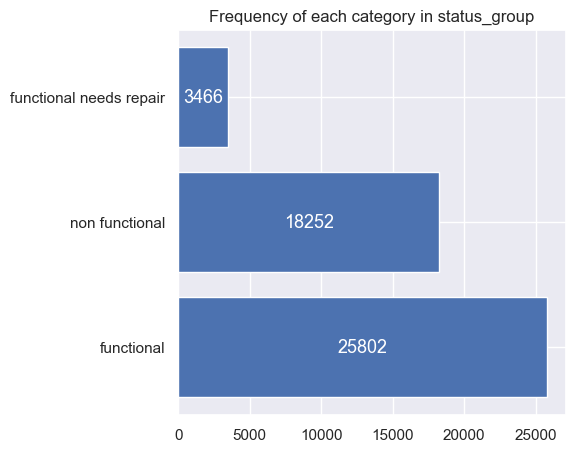

In [277]:
fig, ax = plt.subplots(figsize=(5,5))
counts = y_train.value_counts().sort_values(ascending=False)
barplot = ax.barh(['functional', 'non functional', 'functional needs repair'], list(counts))
ax.bar_label(barplot, labels=list(counts), label_type='center', color='white', fontsize='13');
ax.set_title(f"Frequency of each category in status_group");

In [278]:
#Resampling dataframes for model creation
smote = SMOTE(random_state=state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

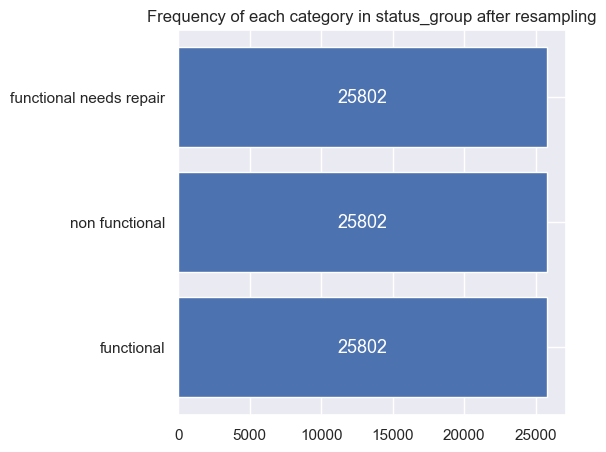

In [279]:
fig, ax = plt.subplots(figsize=(5,5))
counts = y_train_resampled.value_counts().sort_values(ascending=False)
barplot = ax.barh(['functional', 'non functional', 'functional needs repair'], list(counts))
ax.bar_label(barplot, labels=list(counts), label_type='center', color='white', fontsize='13');
ax.set_title(f"Frequency of each category in status_group after resampling");

In [280]:
ratio, predictions, report, matrix, error, estimator = get_results(LogisticRegression(random_state=state), resampled_datasets[4])
display(report.style.set_caption(f"resampling strategy: {ratio}"))

,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.770459,0.218400,0.789803,0.663131,0.592887,0.741427,0.175416
recall,0.665136,0.641598,0.664550,0.663131,0.657095,0.663131,nan
f1-score,0.713934,0.325873,0.721783,0.663131,0.587196,0.690402,nan
support,4572.000000,851.000000,6457.000000,0.663131,11880.000000,11880.000000,nan


# Analysis – Oversampling Effect

If our model is to be successful, we have to predict the "functional needs repair" instances with respectable accuracy. As we can see with our over-sampling technique, we can significantly improve our f1-score in this category, but it will slightly decrease our metrics in other categories.

Testing other over-sampling ratios reveals that resampling "functional needs repair" instances to about 10-15,000 instances is ideal

This still isn't good, so maybe it's time to use different estimators – e.g., random forests, gradient boosting techniques, etc.

In [281]:
for dataset in resampled_datasets[1:4]:
    ratio, predictions, report, matrix, error, estimator = get_results(LogisticRegression(random_state=state), dataset)
    display(report.style.set_caption(f"resampling strategy: {ratio}"))

,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.803152,0.296226,0.743440,0.721717,0.614273,0.734385,0.132108
recall,0.635389,0.368978,0.829333,0.721717,0.611233,0.721717,nan
f1-score,0.709488,0.328624,0.784041,0.721717,0.607384,0.722727,nan
support,4572.000000,851.000000,6457.000000,0.721717,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.812215,0.255589,0.754650,0.702104,0.607484,0.741054,0.124234
recall,0.622485,0.497062,0.785504,0.702104,0.635017,0.702104,nan
f1-score,0.704804,0.337590,0.769768,0.702104,0.604054,0.713809,nan
support,4572.000000,851.000000,6457.000000,0.702104,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.814675,0.228458,0.765278,0.677357,0.602804,0.745834,0.121610
recall,0.614392,0.607521,0.731144,0.677357,0.651019,0.677357,nan
f1-score,0.700499,0.332049,0.747822,0.677357,0.593457,0.699827,nan
support,4572.000000,851.000000,6457.000000,0.677357,11880.000000,11880.000000,nan


# Using different estimators

We will compile results from the following estimators and arrange them in an easily-understood format:

- Logistic Regression (re-do of what we did earlier)
- K Nearest Neighbors with n=3
- Bagging Classifier with a decision tree as its base estimator
- Random Forest
- XG-Boost
- Gradient Boosted Trees with a decision tree as its base estimator
- Extra Randomized Trees

In [282]:
# All the estimators to iterate through.

estimators = {'Logistic Regression': LogisticRegression(), 
              'K-Nearest Neighbors n3': KNeighborsClassifier(n_neighbors=3),
              'Bagging Classifier': BaggingClassifier(estimator=DecisionTreeClassifier()), 
              'Random Forest': RandomForestClassifier(random_state=state), 
              'XG-Boost': XGBClassifier(n_estimators=100, objective='multi:softmax', num_class=3, random_state=state), 
              'Extra Randomized Trees': ExtraTreesClassifier(n_estimators=100, random_state=state)}

In [283]:
# Dictionary for our results
results_dict = {name: None for name in estimators.keys()}

for estimator_name, estimator in estimators.items():
    
    # Helpful ticker #1
    print(f"Estimator: {estimator_name}")
    
    results = {}
    
    for dataset in resampled_datasets:
        
        # Helpful ticker #2
        print(f"Sampling ratio: {dataset[0]}")
        
        ratio, predictions, report, matrix, error, estimator = get_results(estimator, dataset)
        
        # For this particular estimator and resampled dataset, we are recording:
        # 1) Re-sampling strategy, 
        #2) Our predictions, 
        #3) Classification report,
        #4) Confusion matrix,
        #5 Bad error
        results[ratio] = (ratio, predictions, report, matrix, error, estimator)
        
    results_dict[estimator_name] = results
    clear_output(wait=True)

Estimator: Extra Randomized Trees
Sampling ratio: {1: 3466}
Sampling ratio: {1: 10000}
Sampling ratio: {1: 15000}
Sampling ratio: {1: 20000}
Sampling ratio: auto


In [284]:
# Prettifies our results

print("\n")
for estimator_name, results in results_dict.items():
    print(color.BOLD + estimator_name + color.END)
    for ratio, tup in results.items():
        display(tup[2].style.set_caption(f"resampled data (n = {ratio})"))
    print("\n\n")



Logistic Regression


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.794543,0.517949,0.727318,0.745034,0.679937,0.738192,0.135171
recall,0.649606,0.118684,0.895153,0.745034,0.554481,0.745034,nan
f1-score,0.714801,0.193117,0.802555,0.745034,0.570158,0.725127,nan
support,4572.000000,851.000000,6457.000000,0.745034,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.803152,0.296226,0.743440,0.721717,0.614273,0.734385,0.132108
recall,0.635389,0.368978,0.829333,0.721717,0.611233,0.721717,nan
f1-score,0.709488,0.328624,0.784041,0.721717,0.607384,0.722727,nan
support,4572.000000,851.000000,6457.000000,0.721717,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.812215,0.255589,0.754650,0.702104,0.607484,0.741054,0.124234
recall,0.622485,0.497062,0.785504,0.702104,0.635017,0.702104,nan
f1-score,0.704804,0.337590,0.769768,0.702104,0.604054,0.713809,nan
support,4572.000000,851.000000,6457.000000,0.702104,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.814675,0.228458,0.765278,0.677357,0.602804,0.745834,0.121610
recall,0.614392,0.607521,0.731144,0.677357,0.651019,0.677357,nan
f1-score,0.700499,0.332049,0.747822,0.677357,0.593457,0.699827,nan
support,4572.000000,851.000000,6457.000000,0.677357,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.770459,0.218400,0.789803,0.663131,0.592887,0.741427,0.175416
recall,0.665136,0.641598,0.664550,0.663131,0.657095,0.663131,nan
f1-score,0.713934,0.325873,0.721783,0.663131,0.587196,0.690402,nan
support,4572.000000,851.000000,6457.000000,0.663131,11880.000000,11880.000000,nan





K-Nearest Neighbors n3


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.738361,0.401826,0.779182,0.742593,0.639790,0.736441,0.218504
recall,0.738845,0.310223,0.802230,0.742593,0.617100,0.742593,nan
f1-score,0.738603,0.350133,0.790538,0.742593,0.626424,0.739003,nan
support,4572.000000,851.000000,6457.000000,0.742593,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.748309,0.319168,0.784385,0.727609,0.617287,0.737176,0.207568
recall,0.725722,0.414806,0.770172,0.727609,0.636900,0.727609,nan
f1-score,0.736842,0.360756,0.777213,0.727609,0.624937,0.731845,nan
support,4572.000000,851.000000,6457.000000,0.727609,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.751023,0.297686,0.785680,0.721380,0.611463,0.737386,0.205381
recall,0.722441,0.438308,0.757937,0.721380,0.639562,0.721380,nan
f1-score,0.736455,0.354563,0.771559,0.721380,0.620859,0.728179,nan
support,4572.000000,851.000000,6457.000000,0.721380,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.753666,0.293769,0.787938,0.719276,0.611791,0.739350,0.201662
recall,0.719379,0.465335,0.752672,0.719276,0.645795,0.719276,nan
f1-score,0.736124,0.360164,0.769901,0.719276,0.622063,0.727551,nan
support,4572.000000,851.000000,6457.000000,0.719276,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.730179,0.285091,0.797481,0.711953,0.604250,0.734876,0.235564
recall,0.739283,0.460635,0.725724,0.711953,0.641880,0.711953,nan
f1-score,0.734703,0.352201,0.759912,0.711953,0.615605,0.721005,nan
support,4572.000000,851.000000,6457.000000,0.711953,11880.000000,11880.000000,nan





Bagging Classifier


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.750382,0.364525,0.781948,0.744613,0.632285,0.739899,0.213255
recall,0.752187,0.306698,0.796965,0.744613,0.618617,0.744613,nan
f1-score,0.751283,0.333121,0.789385,0.744613,0.624596,0.742038,nan
support,4572.000000,851.000000,6457.000000,0.744613,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.749608,0.308040,0.782974,0.726178,0.613541,0.736112,0.211724
recall,0.732065,0.400705,0.764906,0.726178,0.632559,0.726178,nan
f1-score,0.740733,0.348315,0.773835,0.726178,0.620961,0.730614,nan
support,4572.000000,851.000000,6457.000000,0.726178,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.746498,0.290605,0.789783,0.720623,0.608962,0.737367,0.211942
recall,0.734252,0.428907,0.749419,0.720623,0.637526,0.720623,nan
f1-score,0.740324,0.346464,0.769072,0.720623,0.618620,0.727736,nan
support,4572.000000,851.000000,6457.000000,0.720623,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.755314,0.282559,0.790561,0.721296,0.609478,0.740607,0.203850
recall,0.730534,0.435958,0.752362,0.721296,0.639618,0.721296,nan
f1-score,0.742717,0.342884,0.770989,0.721296,0.618863,0.729442,nan
support,4572.000000,851.000000,6457.000000,0.721296,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.730006,0.263617,0.795494,0.707997,0.596372,0.732191,0.236877
recall,0.748688,0.426557,0.716277,0.707997,0.630507,0.707997,nan
f1-score,0.739229,0.325853,0.753810,0.707997,0.606297,0.717543,nan
support,4572.000000,851.000000,6457.000000,0.707997,11880.000000,11880.000000,nan





Random Forest


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.811357,0.502101,0.781793,0.781061,0.698417,0.773135,0.143920
recall,0.746938,0.280846,0.871148,0.781061,0.632977,0.781061,nan
f1-score,0.777816,0.360211,0.824055,0.781061,0.654027,0.773033,nan
support,4572.000000,851.000000,6457.000000,0.781061,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.822439,0.379673,0.790295,0.771801,0.664136,0.773251,0.131671
recall,0.737533,0.381904,0.847452,0.771801,0.655630,0.771801,nan
f1-score,0.777675,0.380785,0.817876,0.771801,0.658779,0.771095,nan
support,4572.000000,851.000000,6457.000000,0.771801,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.818645,0.352239,0.794553,0.765488,0.655146,0.772141,0.136045
recall,0.737533,0.415981,0.831346,0.765488,0.661620,0.765488,nan
f1-score,0.775975,0.381466,0.812533,0.765488,0.656658,0.767585,nan
support,4572.000000,851.000000,6457.000000,0.765488,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.820450,0.350239,0.794575,0.764394,0.655088,0.772704,0.135608
recall,0.733596,0.430082,0.830262,0.764394,0.664647,0.764394,nan
f1-score,0.774596,0.386076,0.812027,0.764394,0.657566,0.767109,nan
support,4572.000000,851.000000,6457.000000,0.764394,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.798796,0.331593,0.806457,0.757744,0.645615,0.769493,0.162948
recall,0.754593,0.447709,0.800836,0.757744,0.667713,0.757744,nan
f1-score,0.776066,0.381000,0.803637,0.757744,0.653567,0.762751,nan
support,4572.000000,851.000000,6457.000000,0.757744,11880.000000,11880.000000,nan





XG-Boost


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.827971,0.614108,0.753757,0.775000,0.731945,0.772315,0.114829
recall,0.697944,0.173913,0.908781,0.775000,0.593546,0.775000,nan
f1-score,0.757418,0.271062,0.824042,0.775000,0.617507,0.758790,nan
support,4572.000000,851.000000,6457.000000,0.775000,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.838877,0.388042,0.767360,0.762205,0.664760,0.767711,0.106518
recall,0.673010,0.388954,0.874555,0.762205,0.645506,0.762205,nan
f1-score,0.746845,0.388498,0.817458,0.762205,0.650933,0.759555,nan
support,4572.000000,851.000000,6457.000000,0.762205,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.855661,0.320605,0.770801,0.748653,0.649022,0.771210,0.095801
recall,0.667760,0.473561,0.842187,0.748653,0.661169,0.748653,nan
f1-score,0.750123,0.382353,0.804914,0.748653,0.645797,0.753558,nan
support,4572.000000,851.000000,6457.000000,0.748653,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.850860,0.295483,0.779344,0.735774,0.641896,0.772206,0.098863
recall,0.660105,0.553467,0.813381,0.735774,0.675651,0.735774,nan
f1-score,0.743441,0.385276,0.795999,0.735774,0.641572,0.746351,nan
support,4572.000000,851.000000,6457.000000,0.735774,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.814204,0.270198,0.804724,0.723822,0.629708,0.770082,0.142826
recall,0.712161,0.593420,0.749264,0.723822,0.684948,0.723822,nan
f1-score,0.759771,0.371324,0.776004,0.723822,0.635700,0.740769,nan
support,4572.000000,851.000000,6457.000000,0.723822,11880.000000,11880.000000,nan





Extra Randomized Trees


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.802265,0.437819,0.783983,0.773401,0.674689,0.766222,0.150700
recall,0.743657,0.301998,0.856590,0.773401,0.634081,0.773401,nan
f1-score,0.771850,0.357441,0.818680,0.773401,0.649324,0.767618,nan
support,4572.000000,851.000000,6457.000000,0.773401,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.806168,0.358333,0.796421,0.764478,0.653641,0.768791,0.149169
recall,0.743220,0.404230,0.827009,0.764478,0.658153,0.764478,nan
f1-score,0.773415,0.379901,0.811427,0.764478,0.654914,0.765887,nan
support,4572.000000,851.000000,6457.000000,0.764478,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.805542,0.332410,0.794585,0.756313,0.644179,0.765695,0.149825
recall,0.737533,0.423032,0.813536,0.756313,0.658033,0.756313,nan
f1-score,0.770039,0.372285,0.803949,0.756313,0.648758,0.759977,nan
support,4572.000000,851.000000,6457.000000,0.756313,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.810968,0.322357,0.795609,0.754966,0.642978,0.767620,0.143263
recall,0.730971,0.437133,0.813845,0.754966,0.660650,0.754966,nan
f1-score,0.768895,0.371072,0.804624,0.754966,0.648197,0.759817,nan
support,4572.000000,851.000000,6457.000000,0.754966,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.795412,0.315705,0.806206,0.750758,0.639108,0.766916,0.163823
recall,0.750875,0.462985,0.788602,0.750758,0.667487,0.750758,nan
f1-score,0.772502,0.375417,0.797307,0.750758,0.648409,0.757540,nan
support,4572.000000,851.000000,6457.000000,0.750758,11880.000000,11880.000000,nan


# Comparing our base model and our best model

Our first model was a default Logistic Regression estimator with no resampling. Our best model was XG-Boost with a resampling ratio of 10,000. We will now look at the metrics of these models side-by-side.

In [285]:
base_preds = results_dict['Logistic Regression']['{1: 3466}'][1]
best_preds = results_dict['XG-Boost']['{1: 10000}'][1]

base_report = results_dict['Logistic Regression']['{1: 3466}'][2]
best_report = results_dict['XG-Boost']['{1: 10000}'][2]

base_report_df = pd.DataFrame(base_report)
best_report_df = pd.DataFrame(best_report)

display (base_report_df.style.set_caption("base model"))
display (best_report_df.style.set_caption("best model"))

,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.794543,0.517949,0.727318,0.745034,0.679937,0.738192,0.135171
recall,0.649606,0.118684,0.895153,0.745034,0.554481,0.745034,nan
f1-score,0.714801,0.193117,0.802555,0.745034,0.570158,0.725127,nan
support,4572.000000,851.000000,6457.000000,0.745034,11880.000000,11880.000000,nan


,non functional,functional needs repair,functional,accuracy,macro avg,weighted avg,bad_error
precision,0.838877,0.388042,0.767360,0.762205,0.664760,0.767711,0.106518
recall,0.673010,0.388954,0.874555,0.762205,0.645506,0.762205,nan
f1-score,0.746845,0.388498,0.817458,0.762205,0.650933,0.759555,nan
support,4572.000000,851.000000,6457.000000,0.762205,11880.000000,11880.000000,nan


# Visualizations

### One-vs-rest ROC curves

ROC curves are for binary classifiers, not ternary ones. The only way to plot ROC curves is to collapse our ternary classifier into a binary classifier according to each of the three categories, and then plotting a ROC curve each time. So, an ROC curve with non-functional as a reference class would do the following:

- Collapse functional and functional-needs-repair into one category and encode it as 0
- Encode non-functional as 1
- Plot an ROC curve

ROC curves aim to hug the top left corner of the x-y axis. As you can see, our best model outperforms the initial model in every ROC curve, inching closer to the top left corner for every reference class.

In [286]:
# Each map collapses the status variable into a binary classifier according to
# a different reference class
maps = [{0:1, 1:0, 2:0}, 
        {0:0, 1:1, 2:0}, 
        {0:0, 1:0, 2:1}]

# Names for our figures
namez = [f"OVR - Reference class: {Category}" 
         for Category in ['non functional', 'functional needs repair', 'functional']]

In [287]:
# Extracting x-y coordinates from base estimator ROC curve

fig, ax = plt.subplots(2,2, figsize=(15,10))
xdatas, ydatas = [], []
for i in [0,1,2]:
    row = i//2
    col=i%2
    ovr_test = list(y_test.replace(maps[i]))
    ovr_train = list(y_train.replace(maps[i]))
    est = LogisticRegression(random_state=state)
    est.fit(X_train, ovr_train)
    plot = RocCurveDisplay.from_estimator(est, X_test, ovr_test, ax=ax[row][col], name=namez[i]).line_
    xdata = plot.get_xdata()
    ydata = plot.get_ydata()
    xdatas.append(xdata)
    ydatas.append(ydata)
    plt.close(fig)

In [288]:
# Extracting x-y coordinates from best estimator ROC curve

fig, ax = plt.subplots(2,2, figsize=(15,10))
xdatas2, ydatas2 = [], []
for i in [0,1,2]:
    row = i//2
    col=i%2
    ovr_test = list(y_test.replace(maps[i]))
    ovr_train = list(resampled_datasets[1][2].replace(maps[i]))
    est = XGBClassifier(random_state=state)
    est.fit(resampled_datasets[1][1], ovr_train)
    plot = RocCurveDisplay.from_estimator(est, X_test, ovr_test, ax=ax[row][col], name=namez[i]).line_
    xdata = plot.get_xdata()
    ydata = plot.get_ydata()
    xdatas2.append(xdata)
    ydatas2.append(ydata)
    plt.close(fig)

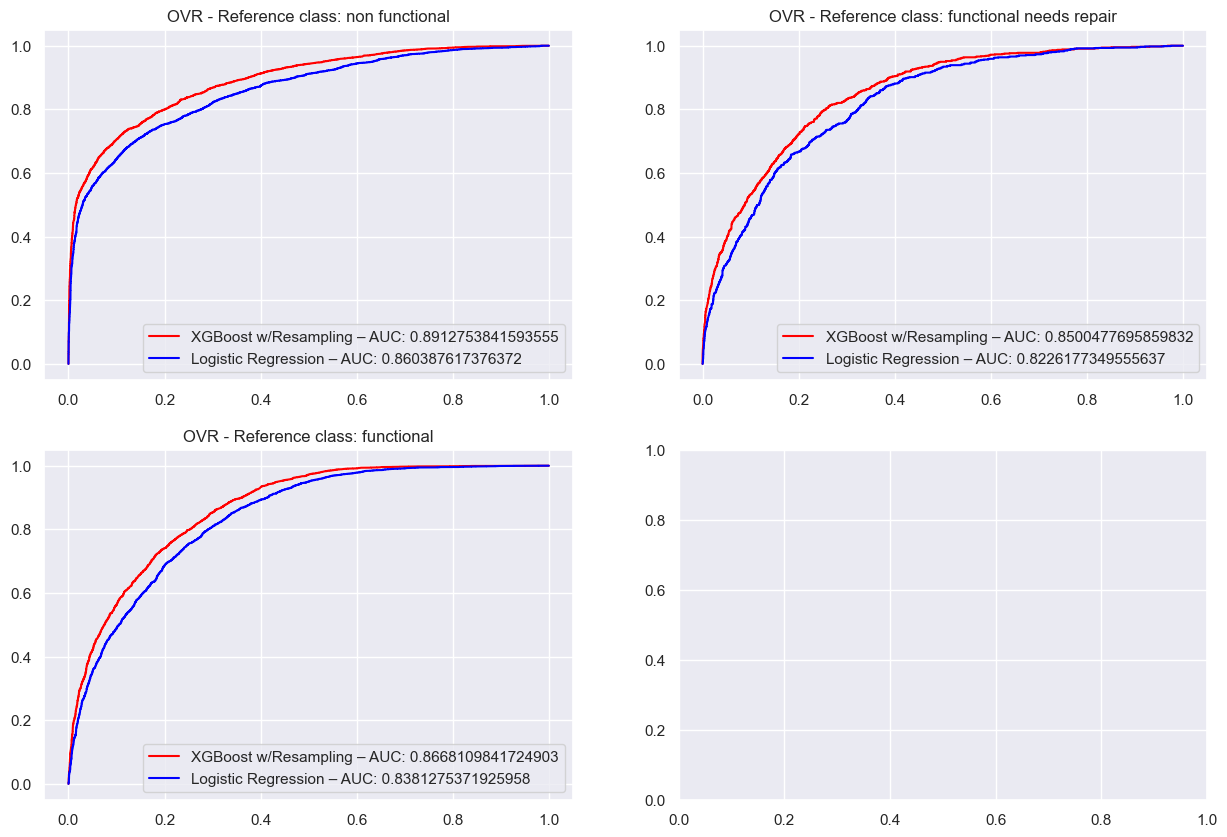

In [289]:
# Plots both sets of curves next to each other

fig, ax = plt.subplots(2,2, figsize=(15,10))
for i in [0,1,2]:
    row = i//2
    col=i%2
    ax[row][col].plot(xdatas2[i], ydatas2[i], color='red', label=f"XGBoost w/Resampling – AUC: {auc(xdatas2[i], ydatas2[i])}")
    ax[row][col].plot(xdatas[i], ydatas[i], color='blue', label=f"Logistic Regression – AUC: {auc(xdatas[i], ydatas[i])}")
    ax[row][col].set_title(namez[i])
    ax[row][col].legend(loc=4)

### Comparing F1 Scores between models

Our best model has a better F1 score for each category.

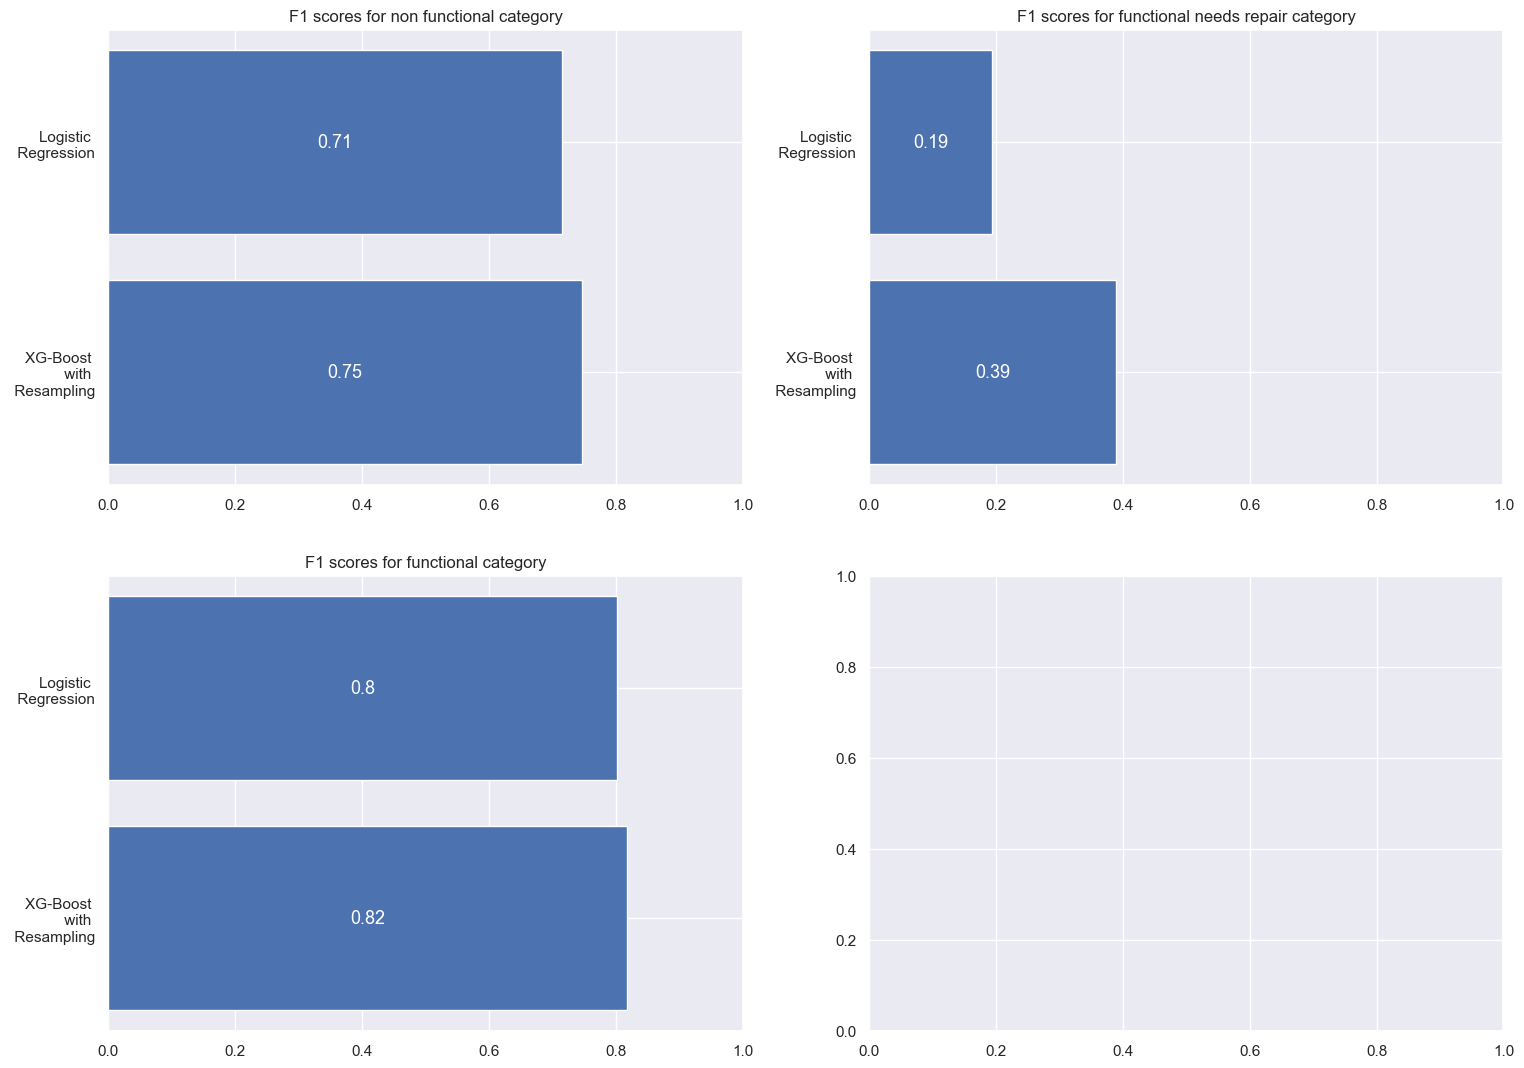

In [290]:
status_map = {0: 'non functional', 1: 'functional needs repair', 2: 'functional'}

fig, ax = plt.subplots(2,2, figsize=(18,13))
for x in [0,1,2]:
    row = x//2
    col=x%2
    f1_scores = [best_report[status_map[x]]['f1-score'], base_report[status_map[x]]['f1-score']]
    ax[row][col].set_title(f"F1 scores for {status_map[x]} category")
    barplot = ax[row][col].barh(['XG-Boost \n with \n Resampling', 'Logistic \n Regression'], f1_scores)
    ax[row][col].bar_label(barplot, labels=[round(i,2) for i in f1_scores], label_type='center', color='white', fontsize='13');
    ax[row][col].set_xlim(0,1);

### Comparing % of Incorrectly Classified Non-Functional Wells

Our first model incorrectly classified 15% of non functional wells as functional wells, meaning that 15% of communities without water were left stranded. Our best model managed to reduce that number to 10%.

(0.0, 1.0)

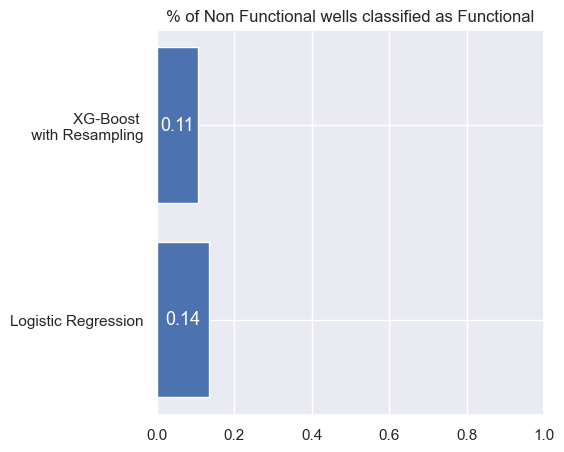

In [291]:
f1_scores = [base_report['bad_error'][0], best_report['bad_error'][0]]

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("% of Non Functional wells classified as Functional")
barplot = ax.barh(['Logistic Regression', 'XG-Boost \n with Resampling'], f1_scores)
ax.bar_label(barplot, labels=[round(i,2) for i in f1_scores], label_type='center', color='white', fontsize='13');
ax.set_xlim(0,1)

### Feature Importances

These feature importances identify features that a random forest deemed highly important when categorizing well status. I pick some of these features and perform some visualizations on them to help inform recommendations for our stakeholders.

In [292]:
model = results_dict['XG-Boost']['{1: 10000}'][5]
importances = model.get_booster().get_score(importance_type='weight')
importances = (sorted(importances.items(), key=lambda x: x[1], reverse=False))[-10:]

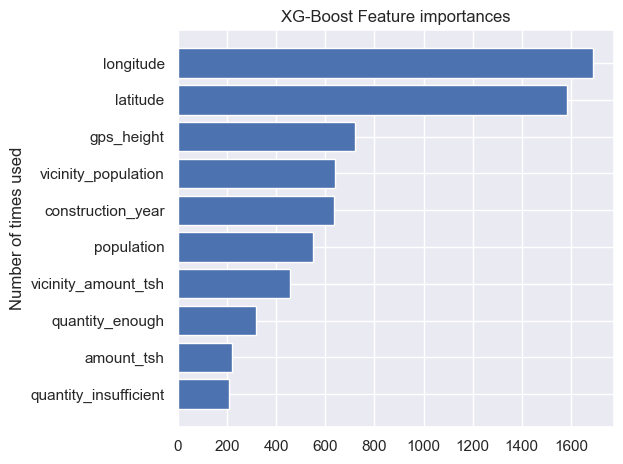

In [293]:
fig, ax = plt.subplots()
ax.barh([i[0] for i in importances], [i[1] for i in importances])
ax.set_title("XG-Boost Feature importances")
ax.set_ylabel("Number of times used")
fig.tight_layout()

### Distribution of construction year for each status

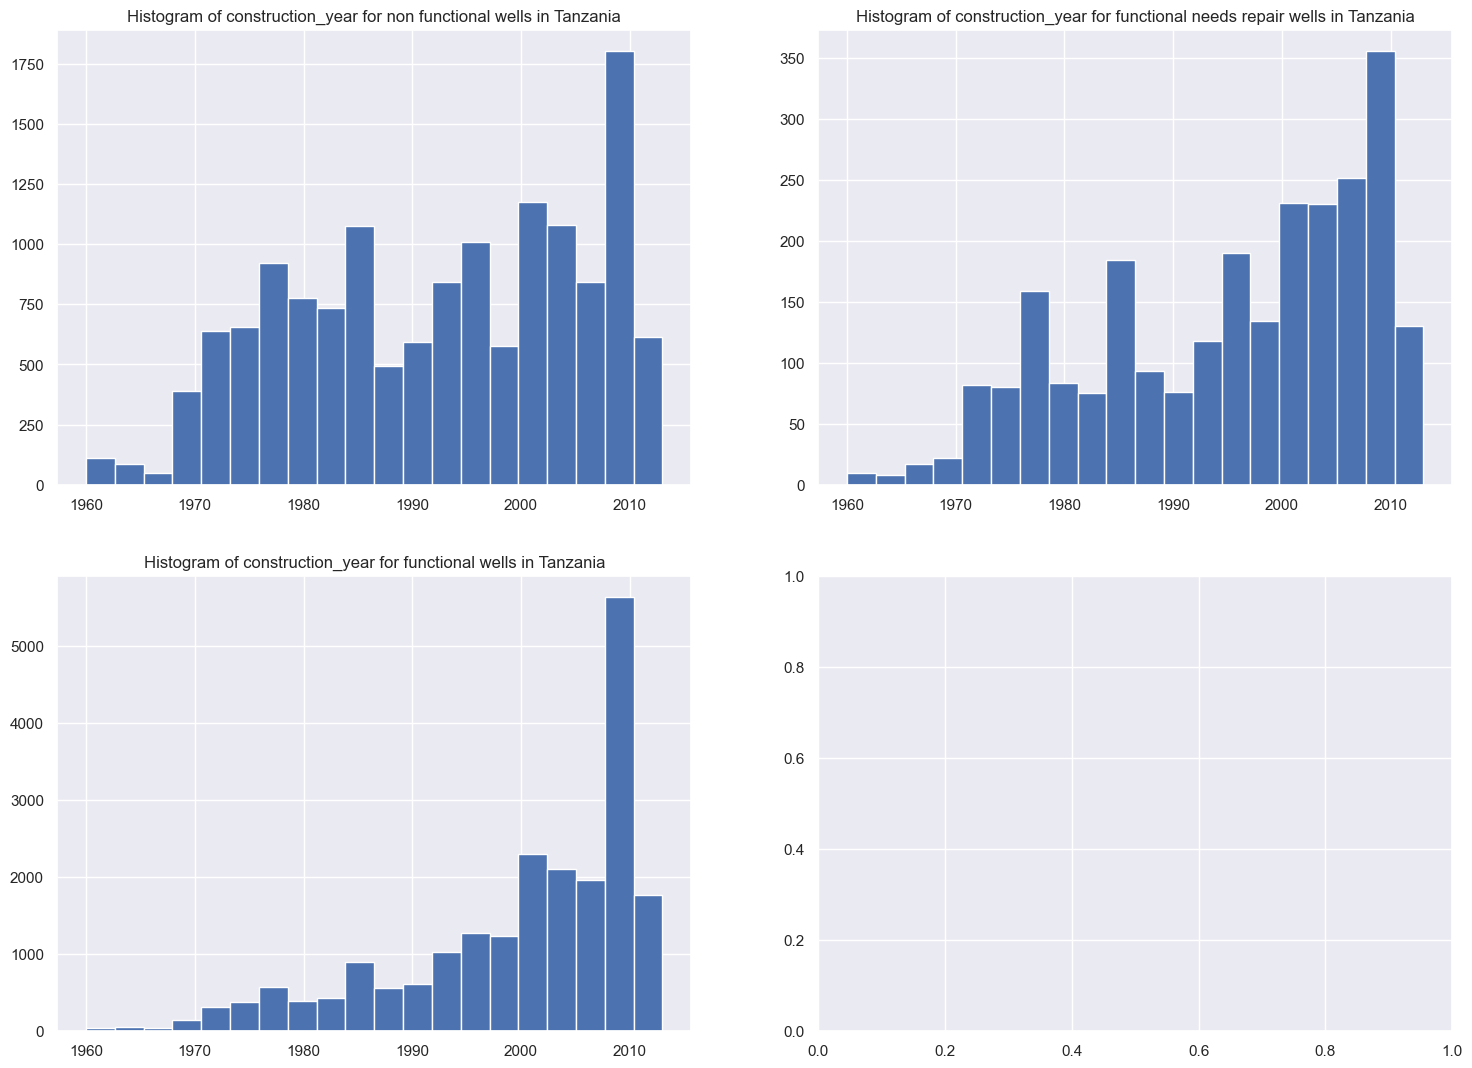

In [294]:
fig, ax = plt.subplots(2,2, figsize=(18,13))
for x in [0,1,2]:
    row = x//2
    col=x%2
    df = geography[(geography.status_group==status_map[x]) & (geography.construction_year!=0)]
    ax[row][col].hist(df.construction_year, bins=20)
    ax[row][col].set_title(f"Histogram of construction_year for {status_map[x]} wells in Tanzania")

### Comparing average amount_tsh for each status

Remember, amount_tsh is the amount of water available to each water point.

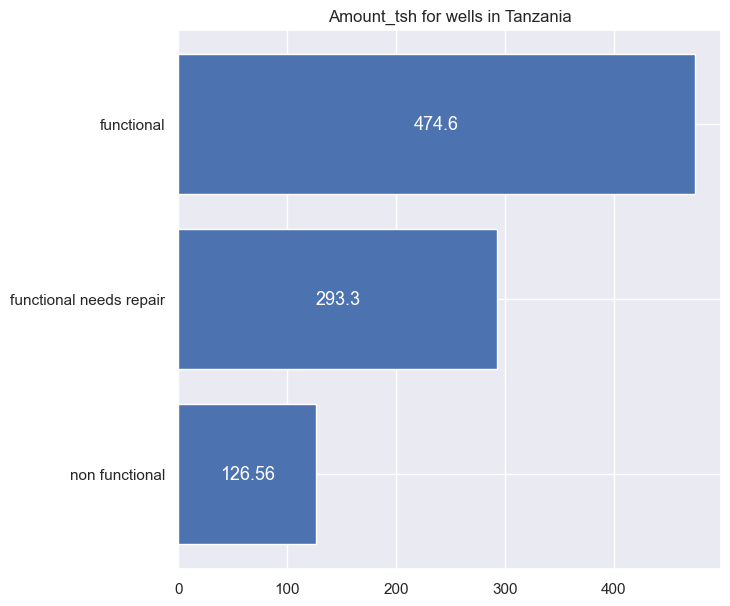

In [295]:
fig, ax = plt.subplots(figsize=(7,7))
df = geography.groupby(by='status_group').mean()['amount_tsh'].sort_values(ascending=True)
barplot = ax.barh(df.index, list(df))
ax.bar_label(barplot, labels=[round(i, 2) for i in list(df)], label_type='center', color='white', fontsize='13');
ax.set_title(f"Amount_tsh for wells in Tanzania");

### Heatmaps of wells across Tanzania, for each status

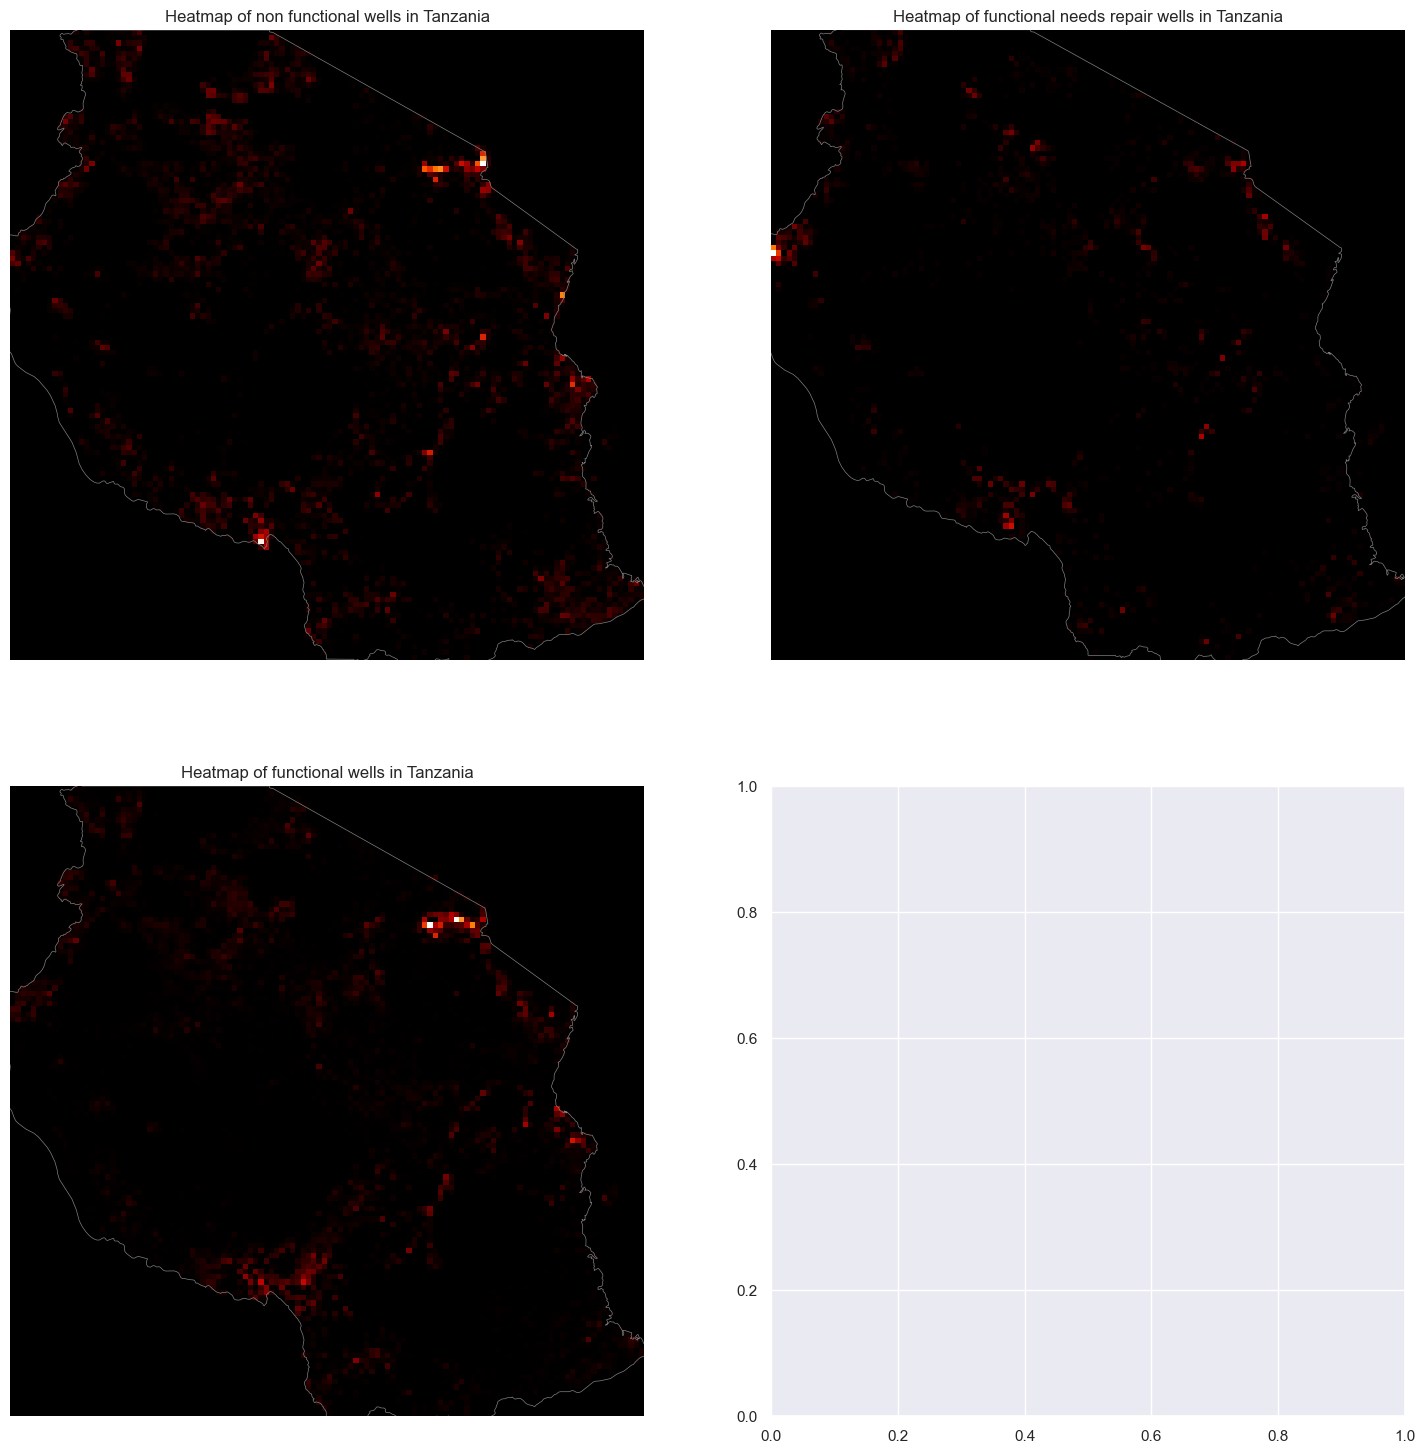

In [296]:
df = gpd.read_file('tanzania_polygon/ne_10m_admin_0_countries.shp')
tanzania = df.iloc[18].copy()
tanzania.geometry = list(list(df.iloc[18])[0].geoms)[0]
xx, yy = tanzania.geometry.exterior.coords.xy
    

fig, ax = plt.subplots(2,2, figsize=(18,18))

for x in [0,1,2]:
    row = x//2
    col=x%2
    df = geography[geography.status_group==status_map[x]]
    ax[row][col].plot(xx, yy, color='grey',  linewidth=0.5)
    ax[row][col].hist2d(df.longitude, df.latitude, bins=120, cmap='gist_heat')
    ax[row][col].set_axis_off()
    ax[row][col].set_title(f"Heatmap of {status_map[x]} wells in Tanzania")

# Recommendations

- Bear in mind that older wells are more likely to be dysfunctional.
- We suggest that the charity organization consult a heatmap of where non functional and functional-needs-repair wells are concentrated to better allocate their resources.
- We suggest that the charity organization prioritize wells that have less water available to them, since these wells are more likely to be non functional or in need of repair.
- Finally, we suggest that the charity organization prioritize non functional over functional-needs-repair wells. Despite making improvements in predicting functional-needs-repair wells, we were unable to achieve satisfactory accuracy in this category. Our best model only idenfitied 43% of all wells in this category, and when the model predicted such a well, it was only correct only 38% of the time.
    - This suggests that the category is ill-defined, and a well in "need of repair" could be almost totally fine, or almost completely broken and just barely functional.

# Pickling model and exporting preprocessed data files

In [297]:
with open('models/xgb_resampled_10k.pkl', 'wb') as f:
    joblib.dump(results_dict['XG-Boost']['{1: 10000}'][5], f)

In [298]:
testing.to_csv('data/X_test_preprocessed.csv', index=False)